# Open Market Backtesting

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
seaborn.set()
import wrds
import sys
sys.path.append('..')

# Import Main Python Modules
from src.dataframe_construction import *
from src.a_estimation import *
from src.optimal_strategies import *
from src.backtest import *


### Backtesting

#### Setting up the data

In [2]:
daily = False
datapath='../data/'

if daily:
    d = 3000
    start_date_a_estimation='2013-01-01'
    end_date_a_estimation='2014-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    start_date='2013-01-01'
    filename='CRSP_2013_2018_daily_cleaned.h5'
    caps_table='dlyprevcap'
    returns_table='dlyret'
else:
    d = 2000
    start_date_a_estimation='1965-01-01'
    end_date_a_estimation='1975-01-01'
    start_date_backtest=end_date_a_estimation
    end_date_backtest='2025-01-01'
    filename='CRSP_monthly_cleaned.h5'
    caps_table='mthprevcap'
    returns_table='mthret'

df_a_estimation = Data(d=d, start_date=start_date_a_estimation, end_date=end_date_a_estimation, datapath=datapath, 
                       filename=filename, caps_table=caps_table, returns_table=returns_table)
df_backtest = Data(d=d, start_date=start_date_backtest, end_date=end_date_backtest, datapath=datapath, filename=filename, 
                   caps_table=caps_table, returns_table=returns_table)

#### Estimating $a$ and Computing Optimal Strategy

/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x) + c
/home/pedro/Downloads/mathematical_finance/2-notebooks/../src/a_estimation.py:25: RuntimeWarning: overflow encountered in multiply
  return a * np.exp(-b * x) + c


[-1.32739873 -1.3236884  -1.31998845 -1.31629884 -1.31261954]


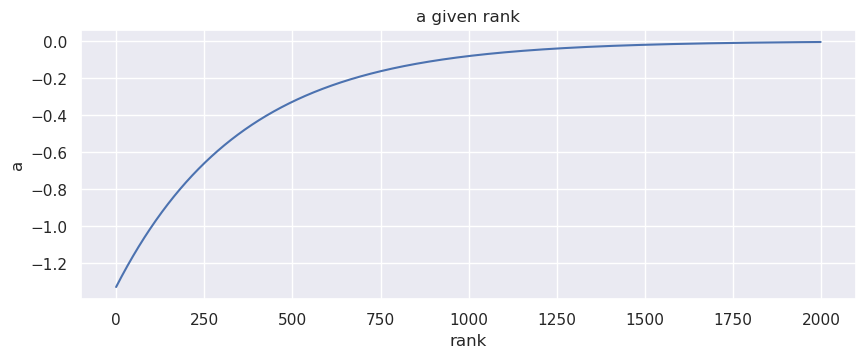

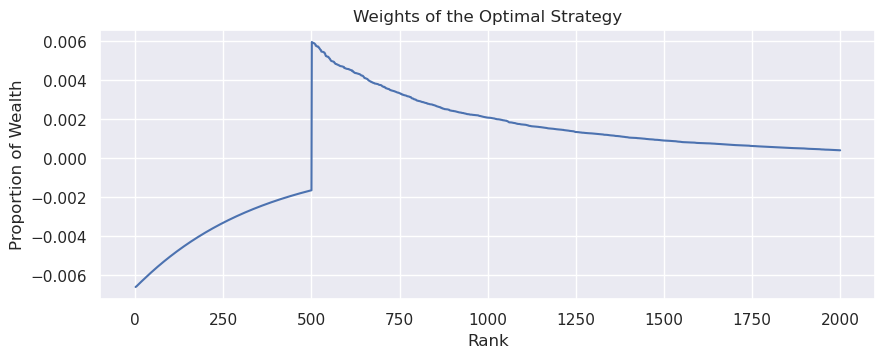

In [3]:
# Estimate a
method = 'direct_log'
smooth_method = 'exponential_decay'
smooth_parameter = 1
smooth_a = False

a = estimate_a(df_a_estimation.weights_by_rank, smooth_method=smooth_method, smooth_parameter=smooth_parameter,  smooth_a=smooth_a)
print(a[:5])
plot_a(a[:-1])

# Compute Strategy
setting = 'mixed'
N = 500
plot_date = '2013-03-28'
leverage_scaler = 0.01

strategy = compute_weights_optimal_open(setting=setting, N=N, a=a, weights_by_rank=df_backtest.weights_by_rank, leverage_scaler=leverage_scaler)
plot_strategy(strategy, plot_date)

#### Compute Optimal Strategy and Backtest

In [4]:
risk_free_rate = 0
backtest = Backtest(strategy=strategy, weights_permno_by_rank=df_backtest.weights_permno_by_rank, 
                    returns_by_permno=df_backtest.returns_by_permno, risk_free_rate=risk_free_rate)

The average return was 1.506 %.
The sd was 0.0845 .
The Sharpe Ratio was 0.1786982248520697 .
The final cumulative interest in the period was 696.8517


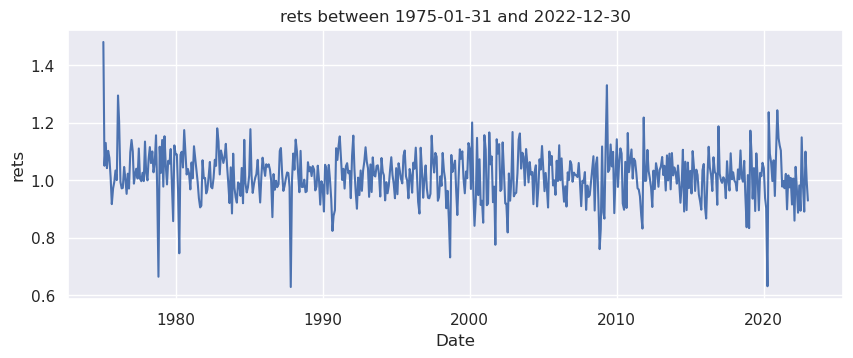

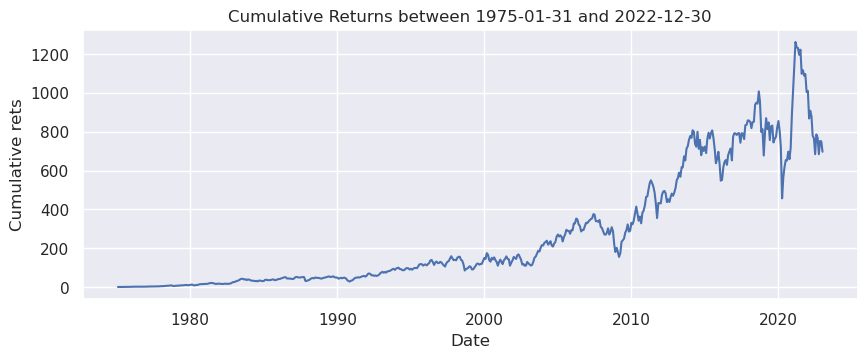

In [5]:
backtest.set_strategy(strategy)
backtest.run()

if backtest.flag_negative_return:
    print('There was at least one negative return during the backtesting so the cumulative returns contain no information.')
print('The average return was', backtest.average_return_percentage, '%.')
print('The sd was', backtest.sd_return, '.')
print('The Sharpe Ratio was', backtest.sharpe_ratio, '.')
print('The final cumulative interest in the period was', backtest.end_period_cumulative_wealth)
backtest.plot_rets()
backtest.plot_cumulative_rets()

### Backtest log wealth

To backtest the log wealth I used the following formula:
$$
\log V = \pi^{\top} \frac {dX_t}{X_t} - \frac 1 2 \pi^{\top} d[X,X]\pi
$$

Which numerically translates to
$$
\log V_T = \sum_{t=0}^T \left [ \pi^{\top}(t-1) \frac {X_t - X_{t-1}}{X_{t-1}} - \sum_{i,j}\frac 1 2 \pi_i(t-1) d[X_i,X_j]\pi_j(t-1) \right] \\ 
d[X_i, X_j](t) = (X_i(t)-X_i(t-1)) (X_j(t)-X_j(t-1))
$$

In [10]:
backtest.set_strategy(strategy)

In [11]:
backtest.backtest_log_wealth()

[0.0, 0.43429249617978544, 1.7815519230167596, 2.3061954557396955, 2.7454940685982168]
[0.0, 0.43429249617978544, 1.3472594268369742, 0.524643532722936, 0.4392986128585212]
The average return each month was 1.7607


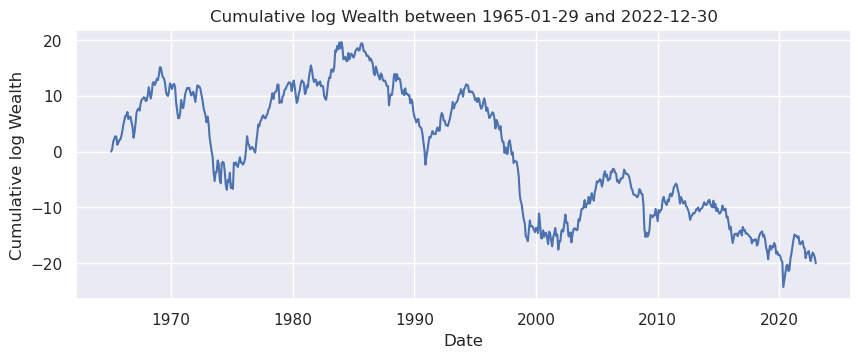

In [14]:
print(backtest.cumulative_log_wealths[0:5])
print(backtest.log_wealths[0:5])

wealth_ratios = np.exp(backtest.log_wealths)
average_wealth_ratio = np.mean(wealth_ratios)

print('The average return each month was',round(average_wealth_ratio, 4))

# backtest.plot_log_wealth()
backtest.plot_cumulative_log_wealth()